In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
from tqdm import tqdm
from sklearn.gaussian_process.kernels import Matern
import math


from IPython.display import set_matplotlib_formats
from matplotlib import cm
set_matplotlib_formats("pdf", "png")
# plt.tight_layout()
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["font.size"] = 28
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 7
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath, amssymb}']

from scipy.stats import multivariate_normal


/var/folders/3t/9g44xm4n6f74bm1skbg0kxdc0000gn/T/ipykernel_9776/330697131.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "png")
/var/folders/3t/9g44xm4n6f74bm1skbg0kxdc0000gn/T/ipykernel_9776/330697131.py:35: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath, amssymb}']


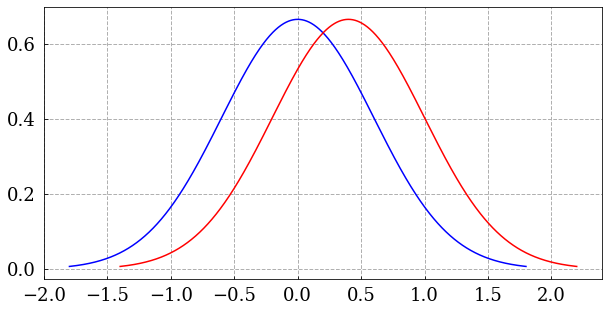

In [2]:
plt.figure(figsize=(10, 5))

cov = 0.8
x1 = 0
mu_y_x = cov * x1
cov_y_x = 1 - cov * cov
precision_y_x = cov_y_x ** (-1)

Y = np.linspace(mu_y_x - 3 * np.sqrt(cov_y_x), mu_y_x + 3 * np.sqrt(cov_y_x), num=1000)
pdf_y_x = 0 * Y
for i in range(len(pdf_y_x)):
    pdf_y_x[i] = (np.sqrt(2 * math.pi) * np.sqrt(cov_y_x)) ** (-1) * np.exp(-0.5 * (Y[i] - mu_y_x) * precision_y_x * (Y[i] - mu_y_x))
plt.plot(Y, pdf_y_x, color = 'b')

x2 = 0.5
mu_y_x = cov * x2
cov_y_x = 1 - cov * cov
precision_y_x = cov_y_x ** (-1)

Y = np.linspace(mu_y_x - 3 * np.sqrt(cov_y_x), mu_y_x + 3 * np.sqrt(cov_y_x), num=1000)
pdf_y_x = 0 * Y
for i in range(len(pdf_y_x)):
    pdf_y_x[i] = (np.sqrt(2 * math.pi) * np.sqrt(cov_y_x)) ** (-1) * np.exp(-0.5 * (Y[i] - mu_y_x) * precision_y_x * (Y[i] - mu_y_x))
plt.plot(Y, pdf_y_x, color = 'r')

plt.show()

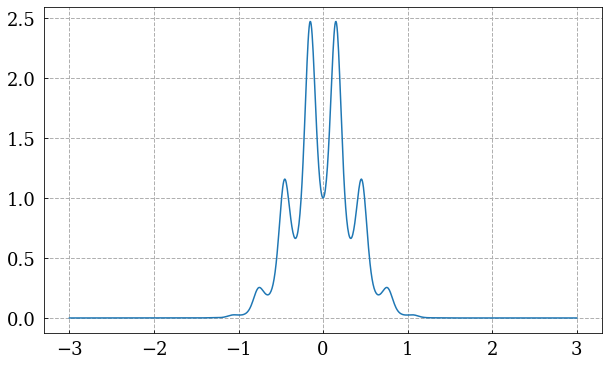

In [3]:
def g(y):
    return np.exp(np.sin(10 * y) ** 2 - 4 * y ** 2)

def g_torch(y):
    return torch.exp(torch.sin(10 * y) ** 2 - 4 * y ** 2)

y = np.linspace(-3, 3, 1000)
plt.figure()
plt.plot(y, g(y))
plt.show()

In [4]:
def int_K(mu, cov, y, sigma):
    return (1 + cov * sigma ** (-2)) ** (-0.5) * np.exp(-0.5 * (sigma ** 2 + cov) ** (-1) * (y - mu) ** 2)
 
from sklearn.gaussian_process.kernels import RBF


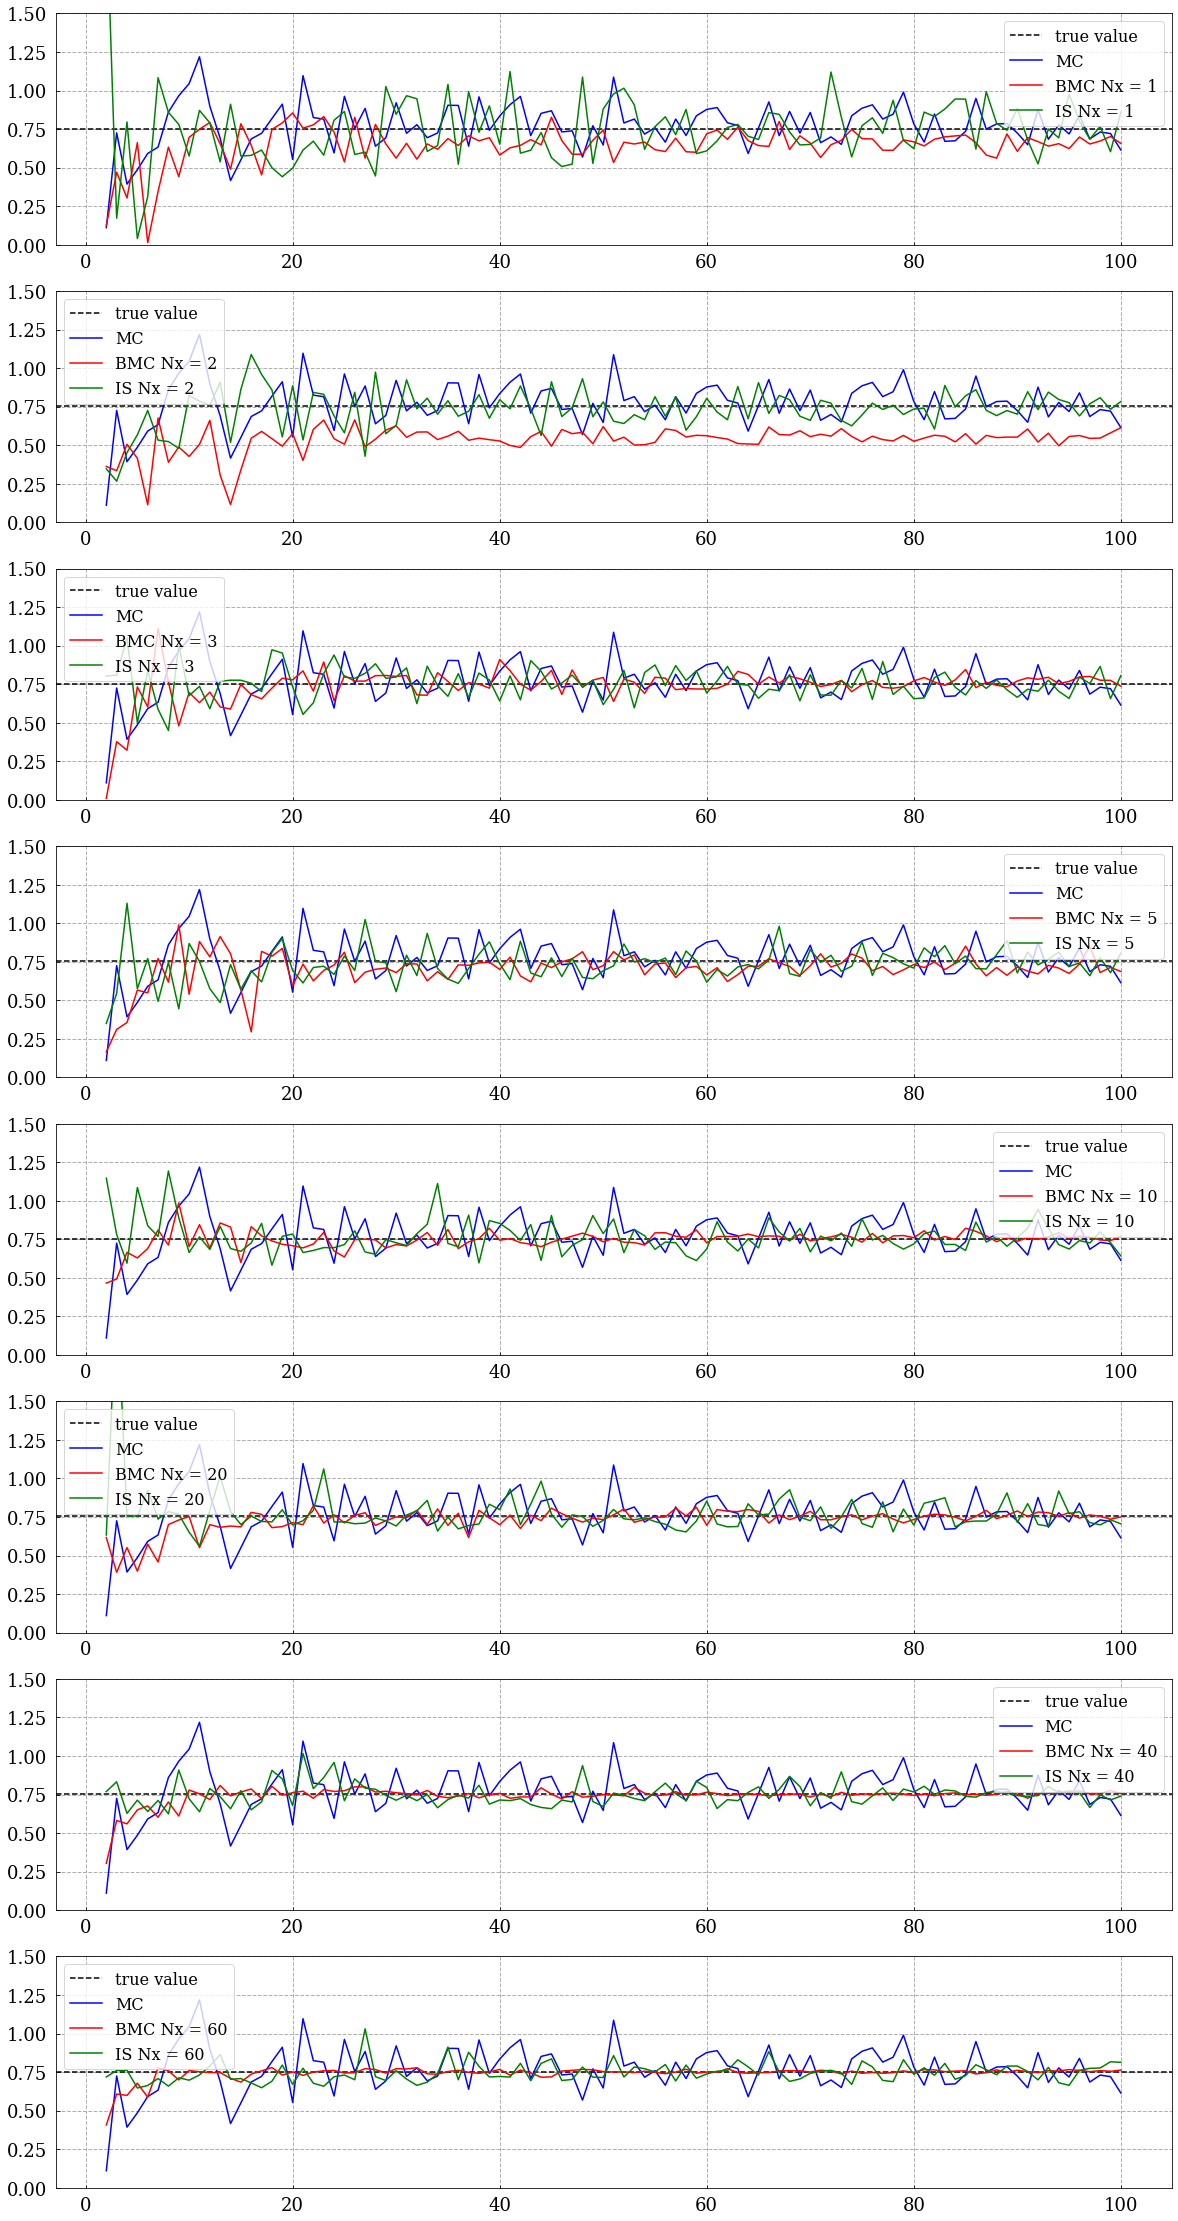

In [5]:
np.random.seed(0)
N = 100
sigma = 0.3

Nx_list = [1, 2, 3, 5, 10, 20, 40, 60]
BMC_dict = {}
Importance_dict = {}

x_pred = 0.5
eps = 1e-2

MC_list = []
mu_y_x = cov * x_pred
cov_y_x = 1 - cov * cov
precision_y_x = cov_y_x ** (-1)

# The MC is based on the conditioning distribution on the true value.
for n in range(1, N+1):
    y_samples = np.random.normal(loc=mu_y_x, scale=np.sqrt(cov_y_x), size=n)[:, None]
    gY = g(y_samples)
    int_MC = gY.mean()
    MC_list.append(int_MC)

y = np.random.normal(loc=mu_y_x, scale=np.sqrt(cov_y_x), size=1000000)[:, None]
gy = g(y)
true_value = gy.mean()

# BMC
for Nx in Nx_list:
    BMC_list = []
    x_obs = np.random.normal(loc=0.0, scale=1.0, size=Nx)[:, None]
    for n in range(1, N+1):
        int_BMC_obs = []
        for x in x_obs:
            mu_y_x = cov * x
            cov_y_x = 1 - cov * cov
            precision_y_x = cov_y_x ** (-1)
            y_samples = np.random.normal(loc=mu_y_x, scale=np.sqrt(cov_y_x), size=n)[:, None]

            K_mean = int_K(mu_y_x, cov_y_x, y_samples, sigma)
            K = RBF(length_scale = sigma)(y_samples, y_samples) + eps * np.eye(n)
            gY = g(y_samples)
            int_BMC_obs.append((K_mean.T @ np.linalg.inv(K) @ gY)[0])

        int_BMC_obs = np.array(int_BMC_obs)
        x_pred = np.array([0.5])[:, None]
        Kx = RBF(length_scale = 1.0)(x_obs, x_obs) + eps * np.eye(len(x_obs))
        int_BMC = (RBF(length_scale = 1.0)(x_pred, x_obs) @ np.linalg.inv(Kx) @ int_BMC_obs)[0]
        BMC_list.append(int_BMC)
    BMC_dict[f"{Nx}"] = BMC_list

# Importance Sampling
def gaussian_llk(x, mean, std):
    return (1.0 / (np.sqrt(2 * math.pi) * std)) * np.exp(-(x - mean) ** 2 / 2 / (std ** 2))


mu_y_x_pred = cov * x_pred
cov_y_x_pred = 1 - cov * cov

mu_y_x_obs = []
cov_y_x_obs = []

for Nx in Nx_list:
    importance_sampling_MC_list = []
    x_obs = np.random.normal(loc=0.0, scale=1.0, size=Nx)[:, None]
    for x in x_obs:
        mu_y_x_obs.append(cov * x)
        cov_y_x_obs.append(1 - cov * cov)

    for n in range(1, N+1):
        importance_sampling_MC = 0
        for i in range(len(x_obs)):
            y_samples = np.random.normal(loc=mu_y_x_obs[i], scale=np.sqrt(cov_y_x_obs[i]), size=n)[:, None]
            gY = g(y_samples)
            p_y_x_pred = gaussian_llk(y_samples, mu_y_x_pred, np.sqrt(cov_y_x_pred))
            p_y_x_obs = gaussian_llk(y_samples, mu_y_x_obs[i], np.sqrt(cov_y_x_obs[i]))
            importance_sampling_MC += (gY * p_y_x_pred / p_y_x_obs).mean()
        importance_sampling_MC_list.append(importance_sampling_MC / len(x_obs))
    Importance_dict[f"{Nx}"] = importance_sampling_MC_list
    
fig, axs = plt.subplots(len(Nx_list), 1, figsize=(20, 40))
axs = axs.flatten()

for i, ax in enumerate(axs):
    Nx = Nx_list[i]
    axs[i].set_ylim(0, 1.5)
    axs[i].axhline(y=true_value, linestyle='--', color='black', label='true value')
    axs[i].plot(np.arange(2, N+1), MC_list[1:], color = 'b', label='MC')
    axs[i].plot(np.arange(2, N+1), BMC_dict[f"{Nx}"][1:], color = 'r', label=f'BMC Nx = {Nx}')
    axs[i].plot(np.arange(2, N+1), Importance_dict[f"{Nx}"][1:], color = 'g', label=f'IS Nx = {Nx}')
    axs[i].legend()
plt.show()

# print(x_obs.flatten())

##
The performance is rather stochastic, plot mean and 95% interval. (not two standard deviations).
For BMC, the 95% interval is the same as the two standard deviation.

Consider the number of samples with MC, add all samples that BMC has observed.



100%|██████████████████████████████| 100/100 [00:09<00:00, 10.71it/s]


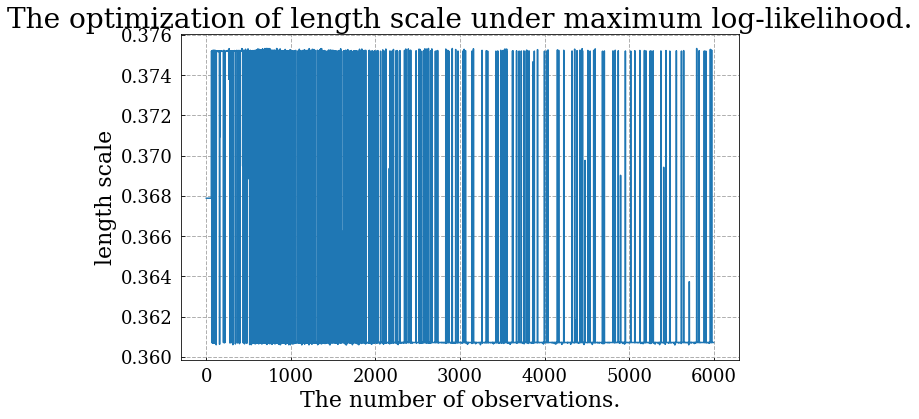

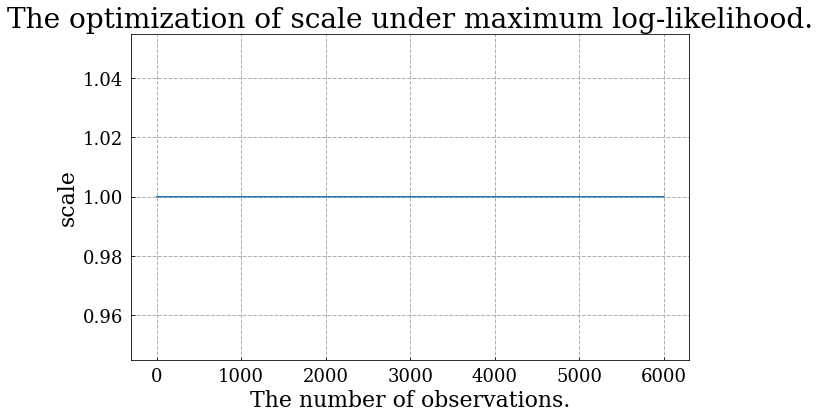

In [6]:
import torch
from torch.autograd import grad
from torch import optim

def RBF_kernel(scale, x_tensor, y_tensor, sigma):
    r = torch.cdist(x_tensor, y_tensor, p=2)
    return scale * torch.exp(- 0.5 * (sigma ** (-2)) * (r ** 1))

n_max = 100
l_list = []
scale_list = []
max_iter = 100

for n in tqdm(range(1, n_max+1)):
    int_BMC_obs = []
    
    for i, x in enumerate(x_obs):
        mu_y_x = cov * x
        cov_y_x = 1 - cov * cov
        precision_y_x = cov_y_x ** (-1)
        y_samples = torch.normal(mean=mu_y_x[0], std=np.sqrt(cov_y_x), size=(n,1))
        
        gy = g_torch(y_samples)
        
        log_l = torch.tensor([-1.0], requires_grad=True)
        scale = torch.tensor([1.0], requires_grad=False)
        optimizer = optim.Adam([log_l, scale], lr=0.01)
        llk_curr = torch.tensor([0.0])
        llk = torch.tensor([1.0])
        
        iteration = 0
        while (torch.abs(llk_curr - llk) > 0.01 and iteration < max_iter):
            llk_curr = llk
            l = torch.exp(log_l)
            K = RBF_kernel(scale, y_samples, y_samples, l)
            K_inv = torch.inverse((K + eps * torch.eye(n * 1)))
            llk = (-0.5 * gy.T @ K_inv @ gy - 0.5 * torch.log(torch.det(K) + eps)) / (n * 1)
            nll = -llk
            nll.backward()
            optimizer.step()
            iteration += 1
            # print(log_l.grad)
            # print(torch.exp(log_l))
        
        l_list.append(torch.exp(log_l).detach().numpy())
        scale_list.append(scale.detach().numpy())
    
plt.figure()
plt.plot(l_list)
plt.title("The optimization of length scale under maximum log-likelihood.")
plt.xlabel("The number of observations.")
plt.ylabel("length scale")
plt.show()

plt.figure()
plt.plot(scale_list)
plt.title("The optimization of scale under maximum log-likelihood.")
plt.xlabel("The number of observations.")
plt.ylabel("scale")
plt.show()

100%|██████████████████████████████| 100/100 [00:13<00:00,  7.50it/s]


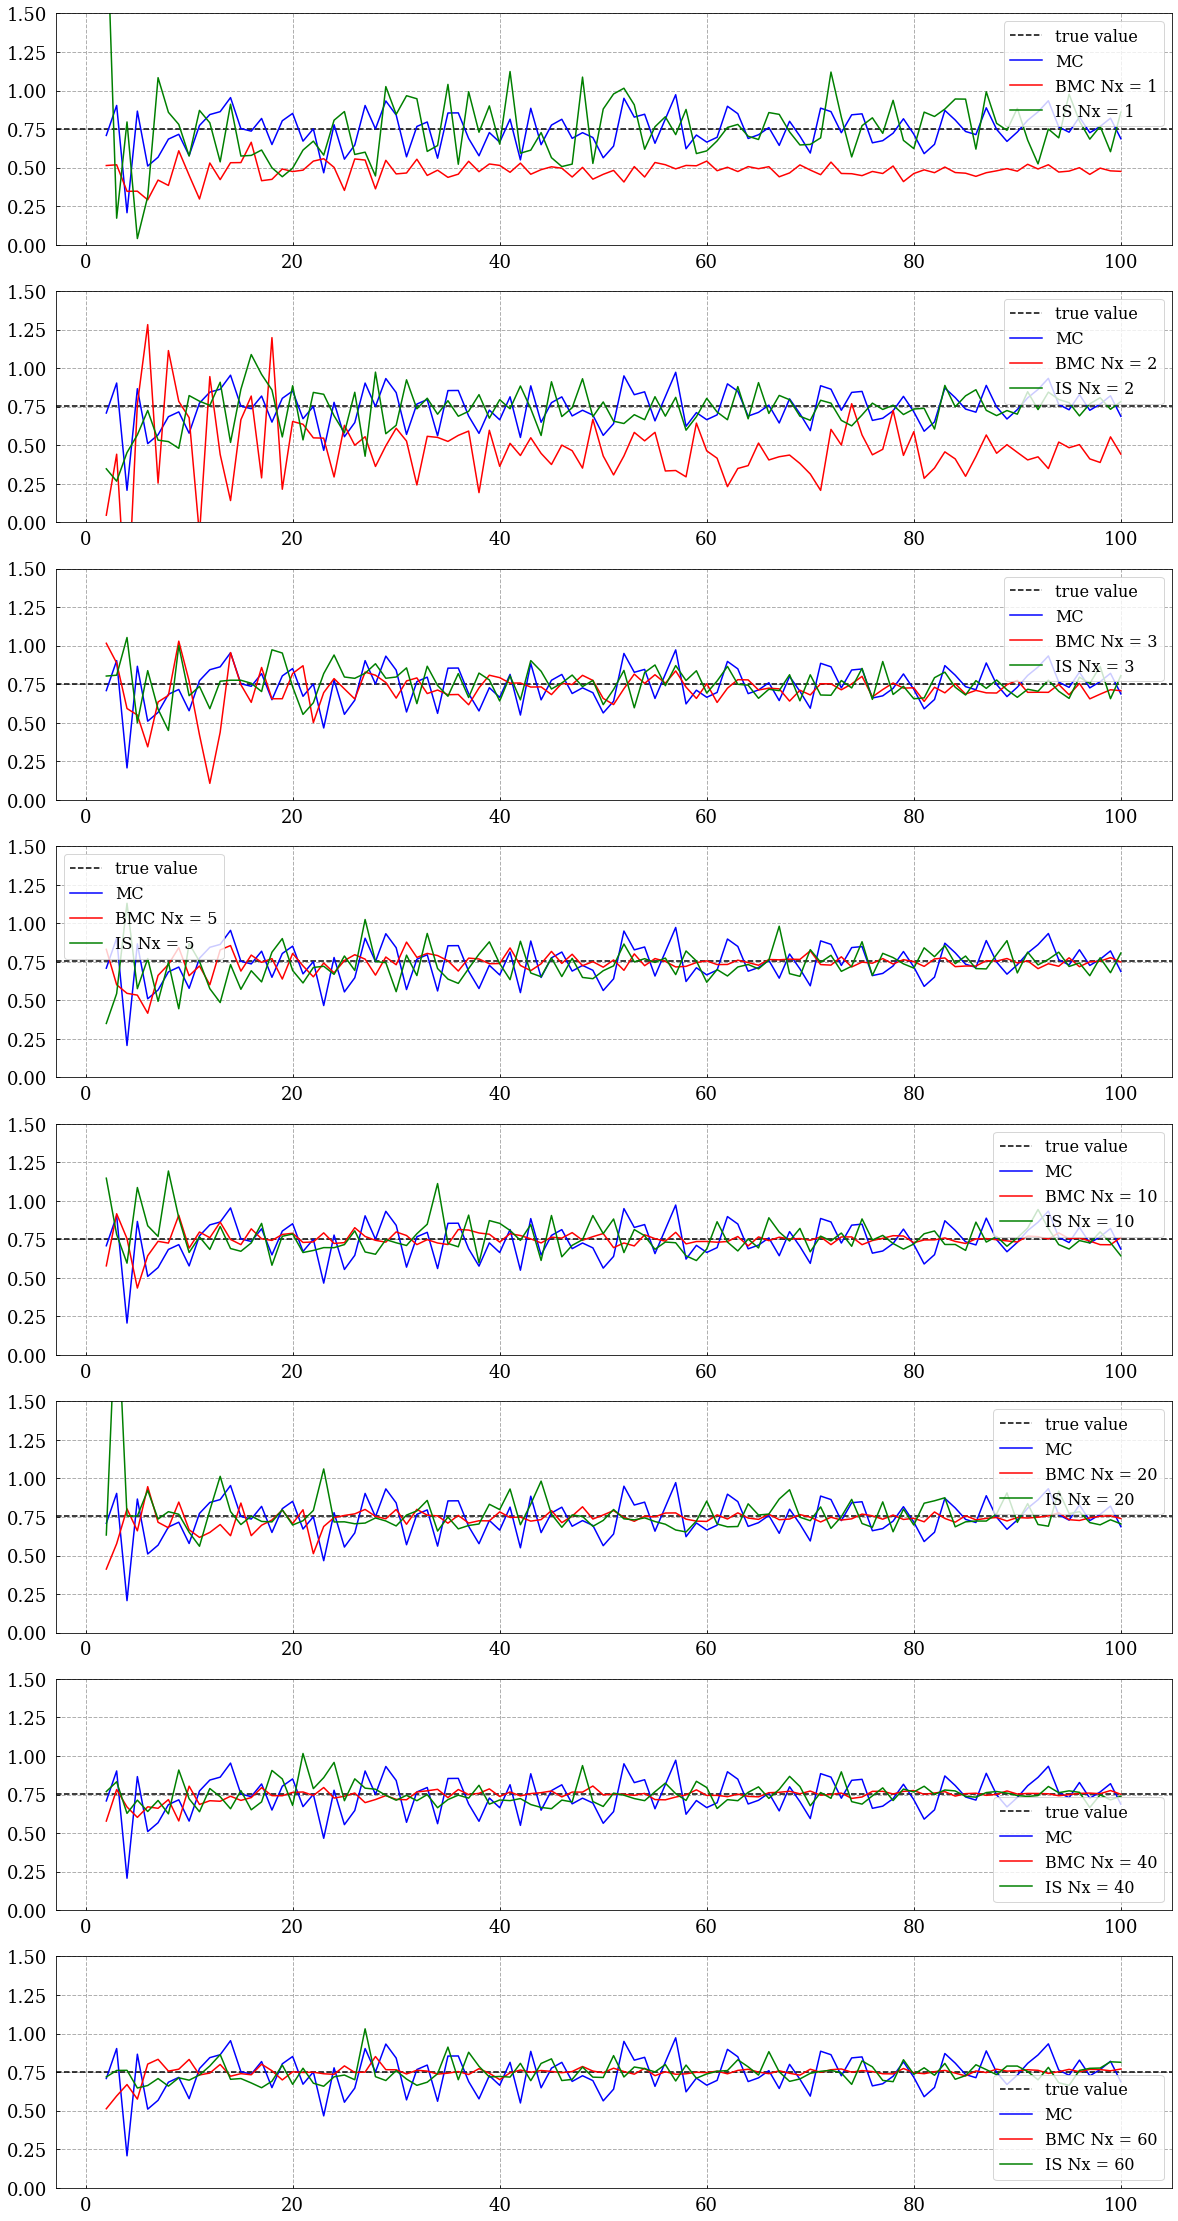

The length scale of x is [0.3606114] and the scale of x is [1.]
The length scale of y is [0.36071366] and the scale of y is [1.]


In [7]:
N = 100
x_pred = 0.5

MC_list = []
mu_y_x = cov * x_pred
cov_y_x = 1 - cov * cov
precision_y_x = cov_y_x ** (-1)

# The MC is based on the conditioning distribution on the true value.
for n in range(1, N+1):
    y_samples = np.random.normal(loc=mu_y_x, scale=np.sqrt(cov_y_x), size=n)[:, None]
    gY = g(y_samples)
    int_MC = gY.mean()
    MC_list.append(int_MC)
    
# BMC
max_iter = 100
BMC_dict = {}
Nx_list = [1, 2, 3, 5, 10, 20, 40, 60]
for Nx in Nx_list:
    BMC_list = []
    x_obs = np.random.uniform(low=0.0, high=1.0, size=Nx)[:, None]
    x_obs_torch = torch.from_numpy(x_obs)
    for n in tqdm(range(1, N+1)):
        int_BMC_obs = []

        # Optimize the y kernel
        for i, x in enumerate(x_obs):
            mu_y_x = cov * x
            cov_y_x = 1 - cov * cov
            precision_y_x = cov_y_x ** (-1)
            y_samples_torch = torch.normal(mean=mu_y_x[0], std=np.sqrt(cov_y_x), size=(n,1))
            gy = g_torch(y_samples_torch)

            log_l = torch.tensor([-1.0], requires_grad=True)
            scale = torch.tensor([1.0], requires_grad=False)
            optimizer = optim.Adam([log_l, scale], lr=0.01)
            llk_curr = torch.tensor([0.0])
            llk = torch.tensor([1.0])
            
            iteration = 0
            while (torch.abs(llk_curr - llk) > 0.01 and iteration < max_iter):
                llk_curr = llk
                l = torch.exp(log_l)
                K = RBF_kernel(scale, y_samples_torch, y_samples_torch, l)
                K_inv = torch.inverse((K + eps * torch.eye(n * 1)))
                llk = (-0.5 * gy.T @ K_inv @ gy - 0.5 * torch.log(torch.det(K) + eps)) / (n * 1)
                nll = -llk
                nll.backward()
                optimizer.step()
                iteration += 1

            length_scale_y = torch.exp(log_l).detach().numpy()
            # print(length_scale_y)
            # length_scale_y = 0.1
            # print(length_scale_y)
            scale_y = scale.detach().numpy()

            y_samples = y_samples_torch.numpy()
            K_mean = scale_y * int_K(mu_y_x, cov_y_x, y_samples, length_scale_y)
            K = scale_y * RBF(length_scale = length_scale_y)(y_samples, y_samples) + eps * np.eye(n)
            gY = g(y_samples)
            int_BMC_obs.append((K_mean.T @ np.linalg.inv(K) @ gY)[0])

        int_BMC_obs = np.array(int_BMC_obs)
        int_BMC_obs_torch = torch.from_numpy(int_BMC_obs)

        # Optimize the x kernel
        log_l_x = torch.tensor([-1.0], requires_grad=True)
        scale_x = torch.tensor([1.0], requires_grad=False)
        optimizer_x = optim.Adam([log_l_x, scale_x], lr=0.01)
        llk_curr_x = torch.tensor([0.0])
        llk_x = torch.tensor([1.0])

        while (torch.abs(llk_curr_x - llk_x) > 0.01):
            llk_curr_x = llk_x
            l = torch.exp(log_l_x)
            K = RBF_kernel(scale_x, x_obs_torch, x_obs_torch, l)
            K_inv = torch.inverse((K + eps * torch.eye(Nx * 1))) # This place is 0.01
            llk_x = (-0.5 * int_BMC_obs_torch.T @ K_inv @ int_BMC_obs_torch - 0.5 * torch.log(torch.det(K) + eps)) / (Nx * 1)
            nll = -llk_x
            nll.backward()
            optimizer_x.step()

        scale_x = scale_x.detach().numpy()
        # scale_x = 0.5
        length_scale_x = torch.exp(log_l_x).detach().numpy()

        x_pred = np.array([0.5])[:, None]
        Kx = scale_x * RBF(length_scale = length_scale_x)(x_obs, x_obs) + eps * np.eye(len(x_obs))
        int_BMC = (scale_x * RBF(length_scale = length_scale_x)(x_pred, x_obs) @ np.linalg.inv(Kx) @ int_BMC_obs)[0]
        BMC_list.append(int_BMC)
    BMC_dict[f"{Nx}"] = BMC_list

fig, axs = plt.subplots(len(Nx_list), 1, figsize=(20, 40))
axs = axs.flatten()

for i, ax in enumerate(axs):
    Nx = Nx_list[i]
    axs[i].set_ylim(0, 1.5)
    axs[i].axhline(y=true_value, linestyle='--', color='black', label='true value')
    axs[i].plot(np.arange(2, N+1), MC_list[1:], color = 'b', label='MC')
    axs[i].plot(np.arange(2, N+1), BMC_dict[f"{Nx}"][1:], color = 'r', label=f'BMC Nx = {Nx}')
    axs[i].plot(np.arange(2, N+1), Importance_dict[f"{Nx}"][1:], color = 'g', label=f'IS Nx = {Nx}')
    axs[i].legend()
plt.show()

print(f"The length scale of x is {length_scale_x} and the scale of x is {scale_x}")
print(f"The length scale of y is {length_scale_y} and the scale of y is {scale_y}")

##
Subtract the mean and divide by standard deviation, (do a standardization for the data)
sklearn, standardization

In [8]:
length_scale_y

array([0.36071366], dtype=float32)